# Sentiment Analysis using Movie Reviews Dataset


## Imports

In [1]:
# after installation and upgrade kernel restart needed
!pip install -q --upgrade keras-nlp
!pip install -q --upgrade keras

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 3.0.4 which is incompatible.


In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

from datetime import datetime
import keras_nlp
import numpy as np
import re
import shutil
import shap
import tensorflow as tf


tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [2]:
# matplotlib settings
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

plt.rc('font', size=10)
plt.rc('axes', labelsize=10, titlesize=12)
plt.rc('legend', fontsize=9)
plt.rc('xtick', labelsize=8)
plt.rc('ytick', labelsize=8)

## Data
1. Load the movie reviews dataset from a source.
2. Split into training/validation subsets using a standard 80/20 split.
3. Overview data, get some basic statistics (vocabulary size, mean/std).
4. Configure datasets for performance.

In [3]:
url = 'https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz'

dataset = tf.keras.utils.get_file('aclImdb_v1.tar.gz', url,
                                  untar=True, cache_dir='.',
                                  cache_subdir='')

dataset_dir = os.path.join(os.path.dirname(dataset), "aclImdb")
os.listdir(dataset_dir)

['train', 'imdb.vocab', 'test', 'README', 'imdbEr.txt']

In [4]:
# set training and testing data paths
train_dir = os.path.join(dataset_dir, "train")
test_dir = os.path.join(dataset_dir, "test")

os.listdir(train_dir)

['urls_pos.txt',
 'urls_unsup.txt',
 'neg',
 'urls_neg.txt',
 'labeledBow.feat',
 'unsupBow.feat',
 'pos',
 'unsup']

In [5]:
# remove unused folders to make it easier to load the data
remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)

In [21]:
# create datasets
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 32
seed = 42

train_ds = tf.keras.utils.text_dataset_from_directory(
    train_dir, batch_size=batch_size, validation_split=0.2,
    subset='training', seed=seed)

val_ds = tf.keras.utils.text_dataset_from_directory(
    train_dir, batch_size=batch_size, validation_split=0.2,
    subset='validation', seed=seed)

test_ds = tf.keras.utils.text_dataset_from_directory(
    test_dir, batch_size=batch_size)

class_labels = train_ds.class_names
print("\nClass names:", class_labels)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.
Found 25000 files belonging to 2 classes.

Class names: ['neg', 'pos']


In [22]:
# data examples
for review, label in train_ds.take(5):
    print(f"\nReview: {review[i]}")
    print(f"Label: {class_labels[label[i]]}: ({label[i]})")


Review: b'The concept of the legal gray area in Love Crimes contributes to about 10% of the movie\'s appeal; the other 90% can be attributed to it\'s flagrant bad-ness. To say that Sean Young\'s performance as a so-called district attorney is wooden is a gross understatement. With her bland suits and superfluous hair gel, Young does a decent job at convincing the audience of her devout hatred for men. Why else would she ask her only friend to pose as a prostitute just so she can arrest cops who try to pick up on them? This hatred is also the only reason why she relentlessly pursues a perverted photographer who gives women a consensual thrill and the driving force behind this crappy movie. Watching Young go from frigid to full-frontal nudity does little to raise interest, but the temper tantrum she throws standing next to a fire by a lake does. Watching her rant and rave about her self-loathing and sexual frustration makes Love Crimes worth the rental fee, but it\'s all downhill to and

In [24]:
# concat reviews texts from train and validation datasets discarding labels 
reviews = tf.concat(([review for review, _ in train_ds.unbatch()], 
                     [review for review, _ in val_ds.unbatch()]), axis=0)
# TextVectorization layer allows efficiently extract vocabulary from the text 
# while optionally appling standardization to it
vectorizer = tf.keras.layers.TextVectorization()
vectorizer.adapt(reviews)
# compute the number of tokens per each review
bows = vectorizer(reviews)
counts = tf.math.count_nonzero(bows, axis=1, keepdims=True)
# get a mean and standard deviation of reviews word counts 
mean, std = tf.math.reduce_mean(counts), tf.math.reduce_std(tf.cast(counts, dtype=tf.float32))

print("Number of unique words in both train and valid datasets:", vectorizer.vocabulary_size())
print(f"Reviews contain {mean} words on average, with standard deviation of {std} words")

Number of unique words in both train and valid datasets: 121894
Reviews contain 232 words on average, with standard deviation of 173.0606689453125 words


In [25]:
# configure datasets for performance
train_ds = train_ds.cache().prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.cache().prefetch(tf.data.AUTOTUNE)

## Model Setup
1. Create utility functions for model training and performance comprarison 
2. Set up a baseline model performance (using pre-trained model, no fine-tuning)

The model used throughout the notebook for this task is pretrained BERT classifier, specifically its "bert_tiny_en_uncased" variant provided by KerasNLP, where backbone model is already fine-tuned on the SST-2 sentiment analysis dataset.

In [34]:
# utility function to load the model
def get_model(dropout=0.1):
    """Returns bert_tiny_en_uncased model optionally appling
    dropout, where droput=0.1 is the default."""
    
    model = keras_nlp.models.BertClassifier.from_preset(
        "bert_tiny_en_uncased_sst2",
        num_classes=2,
        dropout=dropout,
    )
    return model

In [27]:
model = get_model()
model.summary(expand_nested=True)

Preprocessor: "bert_preprocessor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Tokenizer (type)                                   ┃                                             Vocab # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ bert_tokenizer (BertTokenizer)                     │                                              30,522 │
└────────────────────────────────────────────────────┴─────────────────────────────────────────────────────┘

Model: "bert_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃     Param # ┃ Connected to                   ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)     │ (None, None)              │           0 │ -                              │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ segment_ids (InputLayer)      │ (None, None)              │           0 │ -                              │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │           0 │ -                              │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│ bert_backbone (BertBackbone)  │ [(None, 128), (None,      │   4,385,920 │ padding_mask[0][0],            │
│                               │ None, 128)]               │             │ segment_ids[0][0],             │
│                               │                           │             │ token_ids[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│    └ token_ids (InputLayer)   │ (None, None)              │           0 │ -                              │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│    └ token_embedding          │ (None, None, 128)         │   3,906,816 │ -                              │
│ (ReversibleEmbedding)         │                           │             │                                │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│    └ segment_ids (InputLayer) │ (None, None)              │           0 │ -                              │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│    └ position_embedding       │ (None, None, 128)         │      65,536 │ -                              │
│ (PositionEmbedding)           │                           │             │                                │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│    └ segment_embedding        │ (None, None, 128)         │         256 │ -                              │
│ (Embedding)                   │                           │             │                                │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│    └ add (Add)                │ (None, None, 128)         │           0 │ -                              │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│    └ embeddings_layer_norm    │ (None, None, 128)         │         256 │ -                              │
│ (LayerNormalization)          │                           │             │                                │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│    └ embeddings_dropout       │ (None, None, 128)         │           0 │ -                              │
│ (Dropout)                     │                           │             │                                │
├───────────────────────────────┼───────────────────────────┼─────────────┼────────────────────────────────┤
│    └ padding_mask             │ (None, None)              │           0 │ -                              │
│ (InputLayer)                  │                           │             │                                │
├───────────────────────────────┼───────────────────────────┼─────────────┼─

 Total params: 4,386,178 (16.73 MB)

 Trainable params: 4,386,178 (16.73 MB)

 Non-trainable params: 0 (0.00 B)

In [28]:
# save model performance to compare later
accuracy = {}

In [19]:
# evaluate base model with default parameters
model = get_model()
# get model's preset learning rate
print("Default learning rate:", model.optimizer.get_config()["learning_rate"])
_ = model.fit(train_ds, validation_data=val_ds, epochs=1)
# get performance
accuracy["Baseline"] = (model.evaluate(train_ds, return_dict=True, verbose=0)["sparse_categorical_accuracy"], 
                        model.evaluate(test_ds, return_dict=True, verbose=0)["sparse_categorical_accuracy"])
print("Baseline model performance on the test set:", accuracy["Baseline"][1])

Default learning rate: 4.999999873689376e-05
625/625 ━━━━━━━━━━━━━━━━━━━━ 36s 33ms/step - loss: 0.3977 - sparse_categorical_accuracy: 0.8210 - val_loss: 0.3355 - val_sparse_categorical_accuracy: 0.8536
Baseline model performance on the test set: 0.8532000184059143


## Model Fine-Tuning
1. Fine-tune model using general recommendations for BERT model fine-tuning stability (https://www.lsv.uni-saarland.de/wp-content/publications/2020/On_the_Stability_of_Fine-tuning_BERT_preprint.pdf): increase number of training steps (20 epochs), using learning rate of size 2e-5, increasing learning rate for the first 10% of of steps and linearly decayed to zero afterward, use early stopping.
2. Apply simple form of fine-tuning using constant learning rate of size 2e-5, decreasing the number of epochs to 5.
3. Experiment with different model hyperparameters set (increase the number of epochs, constant learning rate, early stopping).
4. Compare the results with the established baseline.

In [29]:
# helper function to visualize model training curves
def plot_history(history):
    """Plots training curves given training and validation 
    (accuracy, loss) keys provided in the history."""

    # get keys from the dictionary 
    hist_keys = list(history.history.keys())
    # performance plot
    _, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 3))
    ax1.plot(history.history[hist_keys[0]])
    ax1.plot(history.history[hist_keys[2]])
    ax1.set_title('Model Loss')
    ax1.set_ylabel(hist_keys[0])
    ax1.set_xlabel('epoch')
    ax1.legend(['train', 'valid'], loc='upper left')
    ax1.grid(True)
    # loss plot
    ax2.plot(history.history[hist_keys[1]])
    ax2.plot(history.history[hist_keys[3]])
    ax2.set_title('Model Accuracy')
    ax2.set_ylabel(hist_keys[1])
    ax2.set_xlabel('epoch')
    ax2.legend(['train', 'valid'], loc='upper right')
    ax2.grid(True)
    plt.tight_layout()
    plt.show()

# def plot compare models
def plot_stats(stats):
    """Given a dictionary of (model name, model performance)
    items outputs comparative plot."""

    mode = ("Train", "Test")
    models = list(stats.keys())
    x = np.arange(len(models))  # the label locations
    y = np.round(np.array(list(accuracy.values())), 3)
    y1, y2 = y[:, 0], y[:, 1]
    width = 0.15  # the width of the bars
    plt.figure(figsize=(4, 3), layout='constrained')
    bar1 = plt.bar(x-0.1, y1, width) 
    bar2 = plt.bar(x+0.1, y2, width)
    plt.bar_label(bar1)
    plt.bar_label(bar2)
    plt.xticks(x, models)
    plt.ylim(0.8)
    plt.title("Models Test Set Performance")
    plt.legend(mode, loc='upper left', ncols=2)
    plt.grid(True)
    plt.show()

In [30]:
# TF Model Optimization is not compatible with keras3 yet
# class copied as is from the official repository: https://github.com/tensorflow/models/blob/v2.15.0/official/modeling/optimization/lr_schedule.py#L92-L162
from typing import Mapping, Any, Union, Optional

class LinearWarmup(tf.keras.optimizers.schedules.LearningRateSchedule):
  """Linear warmup schedule."""

  def __init__(self,
               after_warmup_lr_sched: Union[
                   tf.keras.optimizers.schedules.LearningRateSchedule, float],
               warmup_steps: int,
               warmup_learning_rate: float,
               name: Optional[str] = None):
    """Add linear warmup schedule to a learning rate schedule.

    warmup_lr is the initial learning rate, the final learning rate of the
    init_warmup period is the initial learning rate of lr_schedule in use.
    The learning rate at each step linearly increased according to the following
    formula:
      learning_rate = warmup_lr + step / warmup_steps
                    * (final_warmup_lr - warmup_lr).
    Using warmup overrides the learning rate schedule by the number of warmup
    steps.

    Args:
      after_warmup_lr_sched: tf.keras.optimizers.schedules .LearningRateSchedule
        or a constant.
      warmup_steps: Number of the warmup steps.
      warmup_learning_rate: Initial learning rate for the warmup.
      name: Optional, name of warmup schedule.
    """
    super().__init__()
    self._name = name
    self._after_warmup_lr_sched = after_warmup_lr_sched
    self._warmup_steps = warmup_steps
    self._init_warmup_lr = warmup_learning_rate
    if isinstance(after_warmup_lr_sched,
                  tf.keras.optimizers.schedules.LearningRateSchedule):
      self._final_warmup_lr = after_warmup_lr_sched(warmup_steps)
    else:
      self._final_warmup_lr = tf.cast(after_warmup_lr_sched, dtype=tf.float32)

  def __call__(self, step: int):

    global_step = tf.cast(step, dtype=tf.float32)

    linear_warmup_lr = (
        self._init_warmup_lr + global_step / self._warmup_steps *
        (self._final_warmup_lr - self._init_warmup_lr))

    if isinstance(self._after_warmup_lr_sched,
                  tf.keras.optimizers.schedules.LearningRateSchedule):
      after_warmup_lr = self._after_warmup_lr_sched(step)
    else:
      after_warmup_lr = tf.cast(self._after_warmup_lr_sched, dtype=tf.float32)

    lr = tf.cond(global_step < self._warmup_steps,
                 lambda: linear_warmup_lr,
                 lambda: after_warmup_lr)
    return lr

  def get_config(self) -> Mapping[str, Any]:
    if isinstance(self._after_warmup_lr_sched,
                  tf.keras.optimizers.schedules.LearningRateSchedule):
      config = {
          "after_warmup_lr_sched": self._after_warmup_lr_sched.get_config()}  # pytype: disable=attribute-error
    else:
      config = {"after_warmup_lr_sched": self._after_warmup_lr_sched}  # pytype: disable=attribute-error

    config.update({
        "warmup_steps": self._warmup_steps,
        "warmup_learning_rate": self._init_warmup_lr,
        "name": self._name
    })
    return config

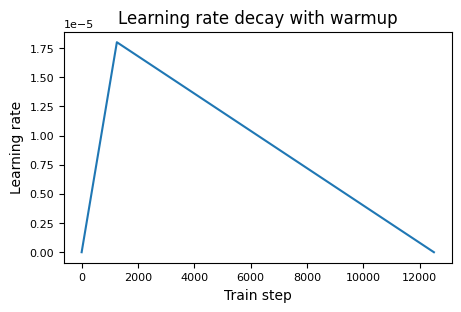

In [35]:
# set up learning rate scheduler (based on BERT stable fine-tuning paper)
epochs = 20
batch_size = 32
steps_per_epoch = train_ds.cardinality().numpy()
num_train_steps = steps_per_epoch * epochs
warmup_steps = int(0.1 * num_train_steps)
initial_learning_rate = 2e-5

# linear learning rate decay applied after "warmup_steps"
linear_decay = tf.keras.optimizers.schedules.PolynomialDecay(
    initial_learning_rate=initial_learning_rate,
    end_learning_rate=0,
    decay_steps=num_train_steps)
# linear warmup for "warmup_steps" steps
warmup_schedule = LinearWarmup(
    warmup_learning_rate=0,
    after_warmup_lr_sched=linear_decay,
    warmup_steps=warmup_steps
)

# plot resulting learning rate scheduling strategy
plt.figure(figsize=(5, 3))
x = tf.linspace(0, num_train_steps, 1001)
y = [warmup_schedule(xi) for xi in x]
plt.plot(x, y)
plt.title("Learning rate decay with warmup")
plt.xlabel('Train step')
plt.ylabel('Learning rate')
plt.show()

Epoch 1/20


I0000 00:00:1707599730.412501   29380 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


625/625 ━━━━━━━━━━━━━━━━━━━━ 36s 33ms/step - loss: 0.4616 - sparse_categorical_accuracy: 0.7827 - val_loss: 0.3876 - val_sparse_categorical_accuracy: 0.8272
Epoch 2/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 31ms/step - loss: 0.3852 - sparse_categorical_accuracy: 0.8303 - val_loss: 0.3399 - val_sparse_categorical_accuracy: 0.8542
Epoch 3/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 19s 31ms/step - loss: 0.3371 - sparse_categorical_accuracy: 0.8562 - val_loss: 0.3181 - val_sparse_categorical_accuracy: 0.8664
Epoch 4/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 19s 30ms/step - loss: 0.3008 - sparse_categorical_accuracy: 0.8736 - val_loss: 0.3026 - val_sparse_categorical_accuracy: 0.8746
Epoch 5/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 19s 31ms/step - loss: 0.2754 - sparse_categorical_accuracy: 0.8877 - val_loss: 0.2966 - val_sparse_categorical_accuracy: 0.8778
Epoch 6/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 31ms/step - loss: 0.2517 - sparse_categorical_accuracy: 0.9008 - val_loss: 0.2956 - val_sparse_categorical_accuracy: 0.8824
Epo

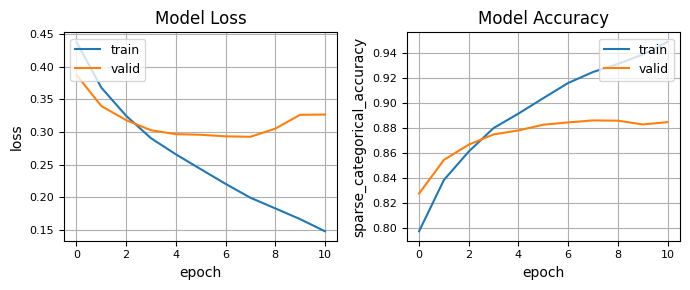

Model performance on the test set: 0.8801199793815613


In [14]:
# train model, save performance
model = get_model(dropout=0.1)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=warmup_schedule), 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              metrics=["sparse_categorical_accuracy"])
e_stop = tf.keras.callbacks.EarlyStopping(patience=3, monitor="val_loss", restore_best_weights=True)
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs,
                   callbacks=[e_stop])

# plot summary
plot_history(history)
accuracy["FT-1"] = (model.evaluate(train_ds, return_dict=True, verbose=0)["sparse_categorical_accuracy"],
                    model.evaluate(test_ds, return_dict=True, verbose=0)["sparse_categorical_accuracy"])
print("Model performance on the test set:", accuracy["FT-1"][1])

Epoch 1/5


I0000 00:00:1707685098.351751    1234 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


625/625 ━━━━━━━━━━━━━━━━━━━━ 41s 34ms/step - loss: 0.4159 - sparse_categorical_accuracy: 0.8122 - val_loss: 0.3343 - val_sparse_categorical_accuracy: 0.8570
Epoch 2/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 19s 31ms/step - loss: 0.3318 - sparse_categorical_accuracy: 0.8601 - val_loss: 0.3227 - val_sparse_categorical_accuracy: 0.8614
Epoch 3/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 19s 31ms/step - loss: 0.2920 - sparse_categorical_accuracy: 0.8778 - val_loss: 0.3019 - val_sparse_categorical_accuracy: 0.8726
Epoch 4/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 19s 31ms/step - loss: 0.2585 - sparse_categorical_accuracy: 0.8954 - val_loss: 0.2895 - val_sparse_categorical_accuracy: 0.8852
Epoch 5/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 32ms/step - loss: 0.2311 - sparse_categorical_accuracy: 0.9082 - val_loss: 0.2866 - val_sparse_categorical_accuracy: 0.8856


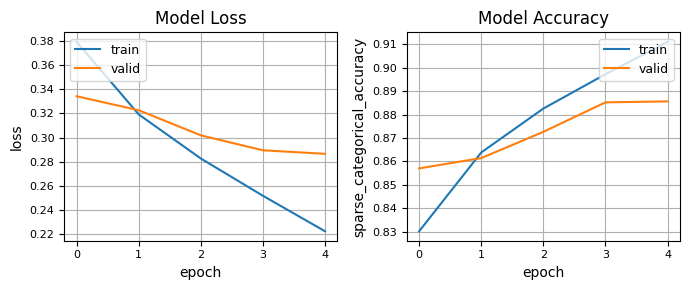

Model performance on the test set: 0.8802800178527832


In [36]:
# default dropout, lower number of training epochs, constant learning rate
model = get_model(dropout=0.1)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5), 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              metrics=["sparse_categorical_accuracy"])
history = model.fit(train_ds, validation_data=val_ds, epochs=5)

# plot summary
plot_history(history)
accuracy["FT-2"] = (model.evaluate(train_ds, return_dict=True, verbose=0)["sparse_categorical_accuracy"],
                    model.evaluate(test_ds, return_dict=True, verbose=0)["sparse_categorical_accuracy"])
print("Model performance on the test set:", accuracy["FT-2"][1])

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 41s 34ms/step - loss: 0.4145 - sparse_categorical_accuracy: 0.8130 - val_loss: 0.3339 - val_sparse_categorical_accuracy: 0.8584
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 19s 31ms/step - loss: 0.3327 - sparse_categorical_accuracy: 0.8588 - val_loss: 0.3180 - val_sparse_categorical_accuracy: 0.8634
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 19s 31ms/step - loss: 0.2917 - sparse_categorical_accuracy: 0.8774 - val_loss: 0.2995 - val_sparse_categorical_accuracy: 0.8720
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 19s 31ms/step - loss: 0.2634 - sparse_categorical_accuracy: 0.8938 - val_loss: 0.2888 - val_sparse_categorical_accuracy: 0.8790
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 19s 31ms/step - loss: 0.2327 - sparse_categorical_accuracy: 0.9106 - val_loss: 0.2873 - val_sparse_categorical_accuracy: 0.8810
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 19s 31ms/step - loss: 0.2000 - sparse_categorical_accuracy: 0.9243 - val_loss: 0.2907 - val_sparse_categorical_accuracy:

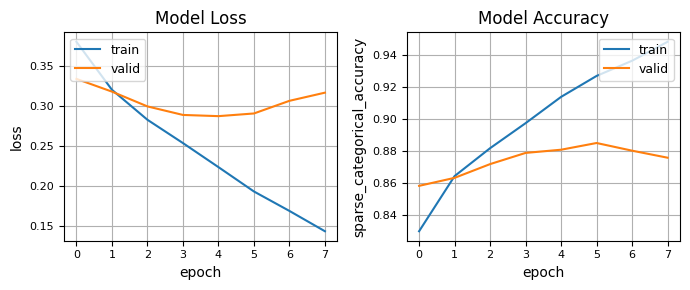

Model performance on the test set: 0.8799999952316284


In [37]:
# increase dropout and number of epochs, add early stopping, constant learning rate
model_2 = get_model(dropout=0.2)
model_2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5), 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              metrics=["sparse_categorical_accuracy"])
e_stop = tf.keras.callbacks.EarlyStopping(patience=3, monitor="val_loss", restore_best_weights=True)
history = model_2.fit(train_ds, validation_data=val_ds, epochs=10,
                     callbacks=[e_stop])
# plot summary
plot_history(history)
accuracy["FT-3"] = (model_2.evaluate(train_ds, return_dict=True, verbose=0)["sparse_categorical_accuracy"],
                    model_2.evaluate(test_ds, return_dict=True, verbose=0)["sparse_categorical_accuracy"])
print("Model performance on the test set:", accuracy["FT-3"][1])

All of the fine-tuned models have impoved the baseline performance, however, model FT-3 clearly overfits the training set, whereas FT-1 and FT-2 have better and almost identical performance. Model FT-2 was easier and faster to train (no learning rate scheduling was applied) compared to the FT-1 (fine-tuned using recommendations from the paper). FT-1 didn't show increased performance for this task. FT-1 model will be used later in the inference process.

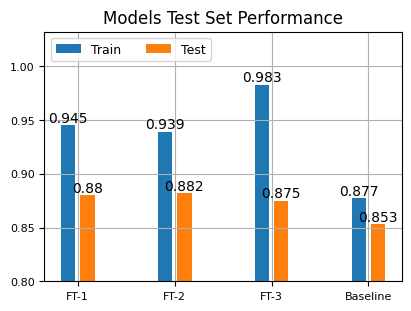

In [20]:
plot_stats(accuracy)

## Inference

Instead of predicting hard sentiment classification labels, it might be more beneficial to map them to the sentiment range from -1 to 1: from negative (-1), neutral(0), to positive(+1).

In [13]:
# helper functions
def make_prediction(raw_review, model):
    """Args: 
    - raw_review: a single review of str type;
    - model: fine-tuned model.
    Outputs:
    - sentiment: a scalar that maps predicted review sentiments
    to fall into range [-1, 1]."""
    # convert a raw review into a tensor + batch dimension
    review = tf.expand_dims(tf.constant(raw_review), axis=0)
    # 2 neurons in the output layer, take the output of only 1 of them
    pred = model.predict(review, verbose=0)[:, 1]
    sentiment = tf.nn.tanh(pred)
    return sentiment.numpy()

def plot_bar(prediction):
    """Given a single scalar prediction plots it in a 
    colormap of a range [-1, 1]."""
    fig, ax = plt.subplots(figsize=(6, 1))
    fig.subplots_adjust(bottom=0.5)
    cmap = mpl.cm.bwr
    norm = mpl.colors.Normalize(vmin=-1, vmax=1)
    ticks = ["negative", "neutral", "positive"]
    bounds = [-1., 0.0, 1.0]
    cb1 = mpl.colorbar.ColorbarBase(ax, cmap=cmap,
                                    norm=norm,
                                    ticks=bounds,
                                    orientation='horizontal')
    cb1.ax.axvline(prediction, c='green', linewidth=3)
    cb1.ax.text(prediction, 1.1, s="prediction: "+str(round(prediction[0], 2)), 
                horizontalalignment="center", fontsize=9, c="green")
    cb1.set_ticklabels(ticks)
    cb1.set_label('Sentiment Scale')

Review: This movies was wonderful, however the music was not that good.


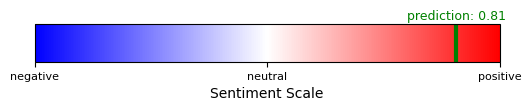

In [26]:
# test model prediction and plot result
review = "This movies was wonderful, however the music was not that good."
print("Review:", review)
plot_bar(make_prediction(review, model))

Review: It was okay, 5 out of 10, but i wouldn't watch it again.


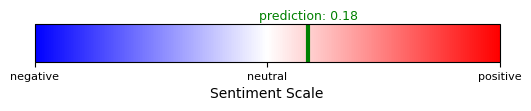

In [27]:
review = "It was okay, 5 out of 10, but i wouldn't watch it again."
print("Review:", review)
plot_bar(make_prediction(review, model))

Review: Movie is completely awful!


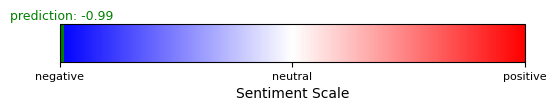

In [28]:
review = "Movie is completely awful!"
print("Review:", review)
plot_bar(make_prediction(review, model))

Review: tf.Tensor(b'The remarkable, sometimes infuriating, often brilliant films of John Cassavetes occupy a unique position in American cinema\xc2\x85 Low-budget, partly improvised, inspired by cin\xc3\xa9ma verit\xc3\xa9 documentary, and related to underground film, they have nevertheless frequently managed to reach a wide and profoundly appreciative audience\xc2\x85 <br /><br />After drama studies, the young Cassavetes quickly made his name as an unusually unrefined, intense actor, often appearing in films about disaffected, rebellious youth such as "Crime in the Streets" and "Edge of the City." <br /><br />Setting up an actors\' workshop, he worked to transform an improvisational experiment into his feature debut\xc2\x85 The result, "Shadows," taking three years to complete and partly financed by his performances in TV\'s Johnny Staccato, was a breakthrough in American cinema\xc2\x85 About the effect of racism on an already fraught relationship between two black men and their siste

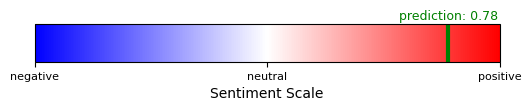

In [29]:
# test a review sampled from the test set
review_label = test_ds.unbatch().take(1)
for review, label in review_label:
    print("Review:", review)
    print("True label:", label.numpy())
    plot_bar(make_prediction(review, model))

## Error Analysis
1. Get a more detailed model performance report (confusion matrix and classification report)
2. Analyze errors using SHAP
3. Retrain model based on main findings from the analysis
4. Compare results

In [38]:
def get_labels(dataset):
    """Returns true labels extracted from a tf.data.Dataset."""
    # get true labels
    return tf.stack([label for _, label in dataset.unbatch()], axis=0)

def get_preds(model, dataset):
    """Given a model and a dataset returns:
    y_pred - predicted labels
    y_proba - predicted class probabilities"""
    # raw model outputs
    logits = model.predict(dataset, verbose=0)
    # class probabilities
    y_proba = tf.nn.softmax(logits)
    # predicted labels
    y_pred = tf.cast(tf.argmax(logits, axis=1), tf.int32)
    return y_pred, y_proba


y_true = get_labels(test_ds)
y_pred, y_proba = get_preds(model, test_ds)

print("Labels:", y_true)
print("Predictions:", y_pred)
print("Probabilities:", y_proba)

Labels: tf.Tensor([1 1 0 ... 0 0 1], shape=(25000,), dtype=int32)
Predictions: tf.Tensor([1 1 1 ... 1 1 1], shape=(25000,), dtype=int32)
Probabilities: tf.Tensor(
[[0.05053853 0.94946146]
 [0.00514021 0.9948598 ]
 [0.15173048 0.8482695 ]
 ...
 [0.01856088 0.98143905]
 [0.46923438 0.5307656 ]
 [0.48067823 0.51932174]], shape=(25000, 2), dtype=float32)


In [50]:
# utility functions to plot confusion matrix
def plot_confusion_matrix(actual, predicted, labels, ds_type):
    """Args:
    - actual - true labels,
    - predicted - predicted labels,
    - labels - class labels,
    - ds_type - inference data split name
    Returns: confusion plot."""
    cm = tf.math.confusion_matrix(actual, predicted)
    ax = sns.heatmap(cm, annot=True, fmt='g')
    sns.set(rc={'figure.figsize':(2, 2)})
    ax.set_title('Confusion matrix of sentiment prediction for ' + ds_type)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    ax.xaxis.set_ticklabels(labels)
    ax.yaxis.set_ticklabels(labels)

def classification_report():
    pass

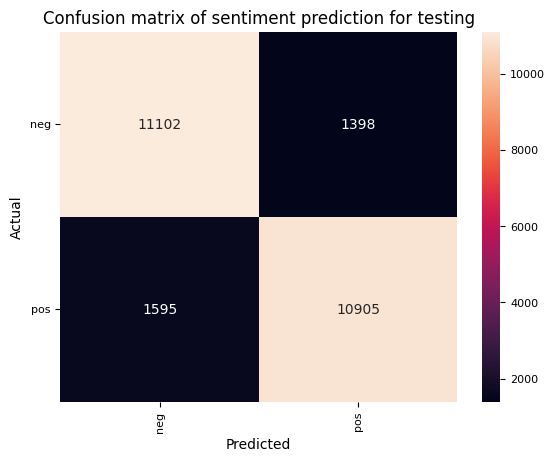

In [40]:
plot_confusion_matrix(y_true, y_pred, class_labels, "testing")

In [41]:
# get a sample of misclassified examples
def sample_misclass(size, dataset, model):
    """Given model, dataset, sample size, returns a 
    sample of misclassified instances"""
    missclass = []
    y_pred, y_proba = get_preds(model, dataset)
    
    for i, item in dataset.unbatch().enumerate():
        if item[1] != y_pred[i]:
            if len(missclass) <= size:
                missclass.append((item, y_proba[i]))
            else:
                break
    return missclass

def make_predictions(X):
    preds = model.predict(X, verbose=0)
    return preds

In [42]:
# output a few misclassified reviews
missclass = sample_misclass(size=10, dataset=test_ds, model=model)

for item, pred in missclass[0:3]:
    print("\nReview:", item[0])
    print(f"True label: {item[1].numpy()} ({class_labels[item[1].numpy()]})")
    print(f"Predicted probability of negative class: {pred.numpy()[0]}, positive class: {pred.numpy()[1]}")


Review: tf.Tensor(b'The one line summary is actually the punch line of a very old joke that begins "what is a Jewish porno film?"<br /><br />While this film had its interesting moments, it was far too slow moving and did not do enough to explain to those of us in the audience unfamiliar with orthodox Jewish custom, exactly what was going on and why? How many people who came across this film would know that the bathtub the female characters were washing in is in reality called a "Mikveh" which is a ritual bath used to cleanse spiritual uncleanliness? The same question might be asked of why the bride was walked around the groom a dizzying number of times while her face was covered just prior to the marriage vows being performed. These two examples are but two of a large number of such moments that remained completely unexplained to the uninitiated audience.<br /><br />This film does have its touching moments along with expressions of great love and emotions. The characters are presented

In [43]:
shap.initjs()

In [44]:
# set up masker and SHAP explainer
masker = shap.maskers.Text(tokenizer=r"\W+")
explainer = shap.Explainer(make_predictions, masker=masker, output_names=class_labels)

# extract review text from the misclassified examples sample
misclass_reviews = [str(text[0].numpy(), encoding='utf-8') for text, label in missclass[:1]]

# SHAP masker applied to the input text
print("Samples:")
for text in misclass_reviews[:1]:
    print(re.split(r"\W+", text))
    print()

Samples:
['The', 'one', 'line', 'summary', 'is', 'actually', 'the', 'punch', 'line', 'of', 'a', 'very', 'old', 'joke', 'that', 'begins', 'what', 'is', 'a', 'Jewish', 'porno', 'film', 'br', 'br', 'While', 'this', 'film', 'had', 'its', 'interesting', 'moments', 'it', 'was', 'far', 'too', 'slow', 'moving', 'and', 'did', 'not', 'do', 'enough', 'to', 'explain', 'to', 'those', 'of', 'us', 'in', 'the', 'audience', 'unfamiliar', 'with', 'orthodox', 'Jewish', 'custom', 'exactly', 'what', 'was', 'going', 'on', 'and', 'why', 'How', 'many', 'people', 'who', 'came', 'across', 'this', 'film', 'would', 'know', 'that', 'the', 'bathtub', 'the', 'female', 'characters', 'were', 'washing', 'in', 'is', 'in', 'reality', 'called', 'a', 'Mikveh', 'which', 'is', 'a', 'ritual', 'bath', 'used', 'to', 'cleanse', 'spiritual', 'uncleanliness', 'The', 'same', 'question', 'might', 'be', 'asked', 'of', 'why', 'the', 'bride', 'was', 'walked', 'around', 'the', 'groom', 'a', 'dizzying', 'number', 'of', 'times', 'while', 

The base value is what the model outputs when the entire input text is masked, while **f_outputclass(inputs)** is the output of the model for the full original input. The SHAP values explain in an addive way how the impact of unmasking each word changes the model output from the base value (where the entire input is masked) to the final prediction value. SHAP requires tensor outputs from the classifier, and explanations works best in additive spaces (logits or information values instead of probabilities).

In [45]:
shap_values = explainer(misclass_reviews)
shap.text_plot(shap_values)

W0000 00:00:1707686142.521453    1229 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [01:24, 84.42s/it]                                                


It turns out that "br" symbols affected model prediction -> retrain model on the cleaned texts to see the difference.

In [46]:
def clean_text(text):
    return tf.strings.regex_replace(text, "<[^>]+>", " ")

train_ds = train_ds.map(lambda x, y: (clean_text(x), y))
val_ds = val_ds.map(lambda x, y: (clean_text(x), y))
test_ds = test_ds.map(lambda x, y: (clean_text(x), y))

Epoch 1/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 38s 34ms/step - loss: 0.4082 - sparse_categorical_accuracy: 0.8165 - val_loss: 0.3344 - val_sparse_categorical_accuracy: 0.8562
Epoch 2/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 31ms/step - loss: 0.3233 - sparse_categorical_accuracy: 0.8623 - val_loss: 0.3090 - val_sparse_categorical_accuracy: 0.8700
Epoch 3/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 31ms/step - loss: 0.2862 - sparse_categorical_accuracy: 0.8831 - val_loss: 0.2962 - val_sparse_categorical_accuracy: 0.8770
Epoch 4/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 31ms/step - loss: 0.2539 - sparse_categorical_accuracy: 0.8976 - val_loss: 0.2870 - val_sparse_categorical_accuracy: 0.8788
Epoch 5/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 32ms/step - loss: 0.2272 - sparse_categorical_accuracy: 0.9112 - val_loss: 0.2849 - val_sparse_categorical_accuracy: 0.8852


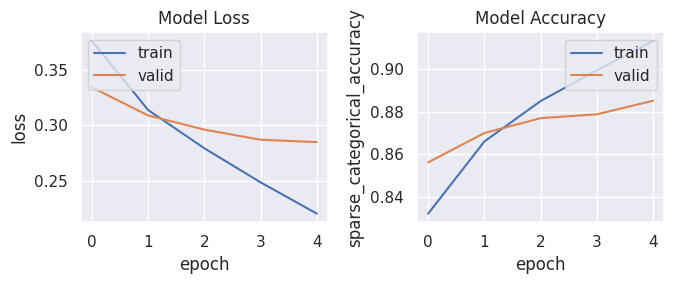

Model performance on the test set: 0.8817600011825562


In [47]:
# default dropout, lower number of training epochs, cleaned inputs
model = get_model(dropout=0.1)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5), 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              metrics=["sparse_categorical_accuracy"])
history = model.fit(train_ds, validation_data=val_ds, epochs=5)

# plot summary
plot_history(history)
accuracy["FT-4"] = (model.evaluate(train_ds, return_dict=True, verbose=0)["sparse_categorical_accuracy"],
                    model.evaluate(test_ds, return_dict=True, verbose=0)["sparse_categorical_accuracy"])
print("Model performance on the test set:", accuracy["FT-4"][1])

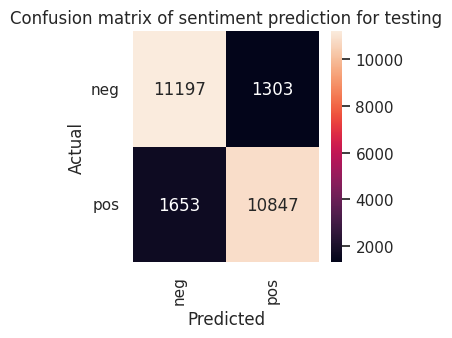

In [51]:
y_true = get_labels(test_ds)
y_pred, y_proba = get_preds(model, test_ds)
plot_confusion_matrix(y_true, y_pred, class_labels, "testing")

In [52]:
# output a few misclassified reviews
missclass = sample_misclass(size=10, dataset=test_ds, model=model)

for item, pred in missclass[0:3]:
    print("\nReview:", item[0])
    print(f"True label: {item[1].numpy()} ({class_labels[item[1].numpy()]})")
    print(f"Predicted probability of negative class: {pred.numpy()[0]}, positive class: {pred.numpy()[1]}")


Review: tf.Tensor(b'The one line summary is actually the punch line of a very old joke that begins "what is a Jewish porno film?"  While this film had its interesting moments, it was far too slow moving and did not do enough to explain to those of us in the audience unfamiliar with orthodox Jewish custom, exactly what was going on and why? How many people who came across this film would know that the bathtub the female characters were washing in is in reality called a "Mikveh" which is a ritual bath used to cleanse spiritual uncleanliness? The same question might be asked of why the bride was walked around the groom a dizzying number of times while her face was covered just prior to the marriage vows being performed. These two examples are but two of a large number of such moments that remained completely unexplained to the uninitiated audience.  This film does have its touching moments along with expressions of great love and emotions. The characters are presented very authentically 

In [53]:
# get only review text from the misclassified examples sample
misclass_reviews = [str(text[0].numpy(), encoding='utf-8') for text, label in missclass[:1]]

explainer = shap.Explainer(make_predictions, masker=masker, output_names=class_labels)
shap_values = explainer(misclass_reviews)
shap.text_plot(shap_values)

W0000 00:00:1707686769.702396    1229 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [01:24, 84.70s/it]                                                


While the model still missclassifies almost the same reviews, it became slightly less confident in its prediction: correct class got more probable: for example, for the SHAP explained example review the probability of the negative (correct) class increased by 25% (from 0.15 to 0.2). This little shift must also explain the overall model accuracy boost on the test set.